<a href="https://colab.research.google.com/github/splAcharya/Imdb_Reviews_Sentiment_Analysis/blob/main/IMDB_Reviews_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string

## Download and Organize Data from Kaggle

In [2]:
os.environ['KAGGLE_USERNAME'] = "hellosomeone" # username from the json file
os.environ['KAGGLE_KEY'] = "9de45792bb324a2134b4d832ce808ea8" # key from the json file

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews #download data from kaggle

 86% 22.0M/25.7M [00:00<00:00, 46.4MB/s]
100% 25.7M/25.7M [00:00<00:00, 64.4MB/s]


In [4]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  sample_data


In [5]:
!mkdir dataset

In [6]:
!unzip -q imdb-dataset-of-50k-movie-reviews.zip -d dataset/

In [7]:
!ls dataset/

'IMDB Dataset.csv'


In [8]:
!mv dataset/"IMDB Dataset.csv" dataset/IMDB_Dataset.csv

In [9]:
!ls dataset/

IMDB_Dataset.csv


In [10]:
!ls

dataset  imdb-dataset-of-50k-movie-reviews.zip	sample_data


In [11]:
!rm  -f imdb-dataset-of-50k-movie-reviews.zip

In [12]:
!ls

dataset  sample_data


## Convert Data to Tensorflow Datasets

In [13]:
raw_data_df = pd.read_csv('dataset/IMDB_Dataset.csv')

In [14]:
raw_data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
raw_data_df['sentiment'] = raw_data_df['sentiment'].apply(lambda row : 1 if row == 'positive' else 0)

In [16]:
raw_data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [17]:
len(raw_data_df[raw_data_df['sentiment'] == 1])

25000

In [18]:
len(raw_data_df[raw_data_df['sentiment'] == 0])

25000

In [19]:
features = raw_data_df['review'].to_numpy()
labels = raw_data_df['sentiment'].to_numpy()

In [20]:
features.shape

(50000,)

In [21]:
labels.shape

(50000,)

In [22]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.4, random_state = 0)

In [23]:
features_valid, features_test, labels_valid, labels_test = train_test_split(features_test, labels_test, test_size=0.5, random_state=0)

In [24]:
features_train = tf.convert_to_tensor(features_train)
labels_train = tf.convert_to_tensor(labels_train)

In [25]:
features_valid = tf.convert_to_tensor(features_valid)
labels_valid = tf.convert_to_tensor(labels_valid)

In [26]:
features_test = tf.convert_to_tensor(features_test)
labels_test = tf.convert_to_tensor(labels_test)

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((features_train, labels_train))
next(iter(train_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement. The absence of violence and porno sex was refreshing. Characters were very convincing and felt like you could understand their feelings. Very enjoyable movie.'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [28]:
valid_ds = tf.data.Dataset.from_tensor_slices((features_valid, labels_valid))
next(iter(valid_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'This version of "The Magic Flute" is not only the worst production of Mozart\'s great opera that I have ever seen, it is also the worst video production I have seen of any opera.<br /><br />I\'m a big opera fan and I have more opera on DVD than movies. The sets are cheap and cheesy. Papageno doesn\'t even have a bird costume. He is just dressed like some guy. The sound is in mono. The color is really bad. It is saturated in orange. Most DVD\'s from this period have the color digitally restored, but they did not bother with this one. Also, the language has been changed to Swedish instead of the original German.<br /><br />This is not a movie version of "The Magic Flute." It is a filmed performance and it is not a good performance and it was not filmed very well. You can pick any other available DVD of this opera and I guarantee it will be better than this one. My preference is for the version conducted by James Levine with sets by David Hockn

In [29]:
test_ds = tf.data.Dataset.from_tensor_slices((features_test, labels_test))
next(iter(test_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b"Leslie Nielson is a very talented actor, who made a huge mistake by doing this film. It doesn't even come close to being funny. The best word to describe it is STUPID!">,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [30]:
BATCH_SIZE = 64

In [31]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE)
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=469>

In [32]:
valid_ds = valid_ds.batch(batch_size=BATCH_SIZE)
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=469>

In [33]:
test_ds = test_ds.batch(batch_size=BATCH_SIZE)
test_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=157>

## Configure dataset for Performance

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Prepare dataset for trainning

In [35]:
def custom_standardization(input_data):
  std_text = tf.strings.lower(input_data)#remove any urls from the text
  std_text = tf.strings.regex_replace(std_text, r"https:\/\/.*[\r\n]*", '')
  std_text = tf.strings.regex_replace(std_text, r"www\.\w*\.\w\w\w", '')
  std_text = tf.strings.regex_replace(std_text, r"<[\w]*[\s]*/>", '')
  std_text = tf.strings.regex_replace(std_text, '[%s]' % re.escape(string.punctuation), '')
  std_text = tf.strings.regex_replace(std_text, '\s{2}', '')
  std_text = tf.strings.strip(std_text)
  return std_text

In [36]:
custom_standardization("Hello ! <br /> I am here. Why are you upset ?").numpy()

b'hello i am here why are you upset'

## Text Encoder

In [37]:
#max_features = 10000
#sequence_length = 250
VOCAB_SIZE = 1000

In [38]:
vectorizer_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE,
                                                                                standardize=custom_standardization)
                                                                                #output_mode='tf_idf')

In [39]:
vectorizer_layer.adapt(train_ds.map(lambda text, label: text))

In [40]:
vocab = np.array(vectorizer_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it',
       'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but',
       'film'], dtype='<U14')

In [41]:
examples, labels = next(iter(train_ds.take(1)))

In [42]:
examples[ : 3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Liked Stanley & Iris very much. Acting was very good. Story had a unique and interesting arrangement. The absence of violence and porno sex was refreshing. Characters were very convincing and felt like you could understand their feelings. Very enjoyable movie.',
       b"The Mummy's Curse is the last in the series of the Kharis mummy films, and it seems that creativity had run somewhat dry by the time they made this one. Kharis and his mate Ananka both end up in the bayous of Louisiana, and on his resurrection, he searches out his beloved princess. How they end up in Louisiana isn't made entirely clear, but with various people trying to find them, the viewer can be assured of some mummy murders.<br /><br />The Mummy's Curse was watchable, but it really wasn't anything special. I had the feeling throughout the movie that I'd seen this before. Quite frankly, apart from the original The Mummy with Boris Karloff, the Mummy movies are no

In [43]:
vectorized_examples = vectorizer_layer(examples)

In [44]:
vectorized_examples.shape

TensorShape([64, 856])

In [45]:
vectorized_examples[ : 3]

<tf.Tensor: shape=(3, 856), dtype=int64, numpy=
array([[410,   1,  51, ...,   0,   0,   0],
       [  2,   1,   1, ...,   0,   0,   0],
       [114,   8, 118, ...,   0,   0,   0]])>

In [46]:
examples.shape

TensorShape([64])

## Create and Train a RNN Model

In [53]:
model = tf.keras.Sequential([ vectorizer_layer,
                              tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, ) ])

In [54]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00088742]


In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


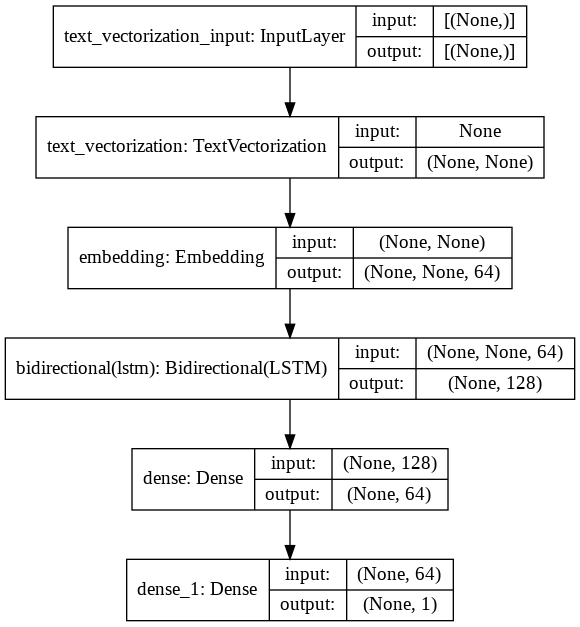

In [60]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [62]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
469/469 [==============================] - 107s 229ms/step - loss: 0.3081 - accuracy: 0.8677 - val_loss: 0.3487 - val_accuracy: 0.8510
Epoch 2/10
469/469 [==============================] - 107s 229ms/step - loss: 0.3059 - accuracy: 0.8685 - val_loss: 0.3522 - val_accuracy: 0.8501
Epoch 3/10
469/469 [==============================] - 108s 229ms/step - loss: 0.3037 - accuracy: 0.8694 - val_loss: 0.3483 - val_accuracy: 0.8502
Epoch 4/10
469/469 [==============================] - 107s 228ms/step - loss: 0.3027 - accuracy: 0.8701 - val_loss: 0.3510 - val_accuracy: 0.8514
Epoch 5/10
469/469 [==============================] - 107s 228ms/step - loss: 0.3008 - accuracy: 0.8704 - val_loss: 0.3563 - val_accuracy: 0.8512
Epoch 6/10
469/469 [==============================] - 107s 228ms/step - loss: 0.2996 - accuracy: 0.8707 - val_loss: 0.3602 - val_accuracy: 0.8502
Epoch 7/10
469/469 [==============================] - 107s 228ms/step - loss: 0.2988 - accuracy: 0.8704 - val_loss: 0.3501 -

In [63]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 14s 87ms/step - loss: 0.3414 - accuracy: 0.8508
Test Loss: 0.3413609266281128
Test Accuracy: 0.8507999777793884


## Plot Learning Curves

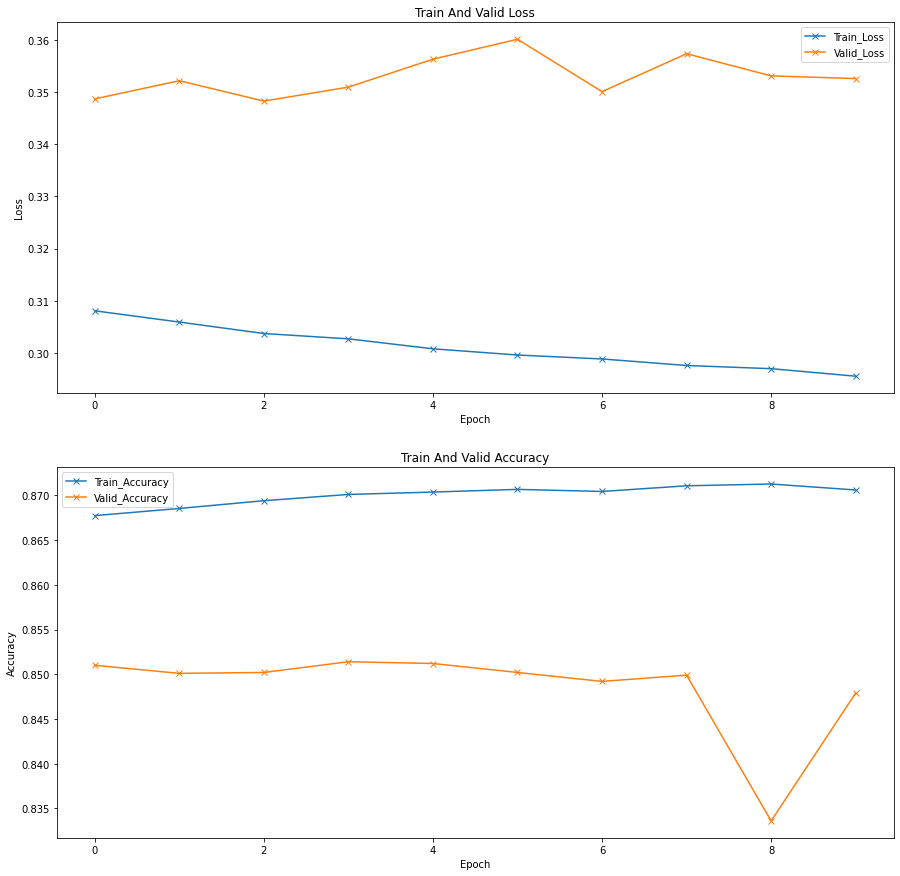

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax[0].plot(history.history["loss"], "x-", label="Train_Loss")
ax[0].plot(history.history["val_loss"], "x-", label="Valid_Loss")
ax[0].title.set_text("Train And Valid Loss")
ax[0].legend(loc="best")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")


ax[1].plot(history.history["accuracy"], "x-", label="Train_Accuracy")
ax[1].plot(history.history["val_accuracy"], "x-", label="Valid_Accuracy")
ax[1].title.set_text("Train And Valid Accuracy")
ax[1].legend(loc="best")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")


plt.show()